In [1]:
"""
author: Julio César Reyes Garibaldi

"""
import sympy as sy
import math
import numpy as np
from sympy.utilities.lambdify import implemented_function
from sympy import lambdify, solve
from sympy.solvers.solveset import nonlinsolve
import matplotlib.pyplot as plt

In [2]:
class SymbolicModel:
    def __init__(self,eqs,pars=None):
        import simpy as sy
        self.eqs = eqs
        self.pars = None
        self._X = None
        self._F = None
        self._loadEqs(eqs)
        return None
        
    def _loadEqs(self,dict):
        """_summary_
        This function should initialize symbolic parameters
        for the functions
        """
        symbolic_vars = []
        symbolic_eqs = []
        for var in self.eqs.keys():
            exec(f"self.{var} = sy.sympify('{var}')")
            exec(f"symbolic_vars.append(self.{var})")
            exec(f"symbolic_eqs.append(sy.sympify(self.eqs['{var}']))")
        self._X = sy.Matrix(symbolic_vars)
        self._F = sy.Matrix(symbolic_eqs)
        self._symbolic_vars = symbolic_vars
        self._symbolic_eqs = symbolic_eqs

    def loadPars(self,pars):
        self.pars = pars.copy()
        
    def convertToExpr(self):
        for var,eq in self.eqs.items():
            _expr = sy.sympify(eq)
            self.expr[var]=_expr

    def evaluateParams(self):
        F_s = self._F.subs(self.pars)
        return F_s
    
    def getEqs(self):
        return None

    def _rk2(self,ic,f,func_pars = None):
        """
        ic -> initial condition as numpy array
        f -> function that applies differential equation to a vector: f(v) = d_t(v)
        time_pars -> timePars = {'starttime':0,'endtime':1000,'step':0.1}
        func_pars ->
        """
        timePars = {'start_time':0,'end_time':1000,'step':0.1,}
        timePars['time'] = np.arange(timePars['start_time'],timePars['end_time'],timePars['step'])
        timePars['n_steps'] = len(timePars['time'])
        U = np.zeros((timePars['n_steps'],np.prod(np.shape(ic))),"float64")
        U[0] = ic
        if func_pars is not None:
            try:
                for i in range (0,timePars['n_steps']-1):
                    k1=f(U[i],func_pars)*timePars['step']/2.0
                    k2=f(U[i]+k1,func_pars)*timePars['step']
                    U[i+1]=U[i]+ k2
            except UnboundLocalError:
                    return U.transpose()
            return U.transpose()
        else:
            try:
                for i in range (0,timePars['n_steps']-1):
                    k1=f(U[i])*timePars['step']/2.0
                    k2=f(U[i]+k1)*timePars['step']
                    U[i+1]=U[i]+ k2
            except UnboundLocalError:
                    return U.transpose()
            return U.transpose()

    def simulate(self,ic):
        F_vw = self.evaluateParams()
        F = lambdify([self.v,self.w],F_vw)
        def F_rk(U):
            v,w = U
            fv,fw = F(v,w).flatten()
            return np.array([fv,fw])
        #
        sol = self._rk2(ic,F_rk)
        return sol
    
    def _lamdify(self,expr):
        return ()
    
    def saveExpressions():
        pass
    
    def _getJacobian(self):
        return self._F.jacobian(self._X).subs(self.pars)
    
    def evaluateJacobian(self,d:dict):
        jacobian = self._getJacobian()
        j_np = np.array(jacobian.subs(d)).astype('float64')
        return j_np.astype('float64')
    
    def calculateEigenValues(self,X):
        eiv,_ = np.linalg.eig(X)
        if eiv.shape[0] == 2:
            l1,l2 = eiv
            tau = l1+l2
            delta = li*l2
            stability = _assignStability(tau,delta)
            return stability
        return None
    
    @staticmethod
    def _assignStability(tau,delta):
        if tau < 0:
            return 'saddle point'
        elif tau == 0:
            return 'non isolated fixed point'
        # up to this point means tau is positive
        if tau**2 - 4*delta < 0:
            if delta > 0:
                return 'unstable node'
            elif delta < 0:
                return 'stable node'
            else: 
                return 'center'
        elif tau**2 - 4*delta > 0:
            if delta > 0:
                return 'unstable spiral'
            elif delta < 0:
                return 'stable spiral'
            else: 
                return 'center'
        else: return 'degenerate node'

    def findFixedPoints(self):
        """
        Necesito, conjunto de ecuaciones igualadas a cero -> F
                  conjunto de parámetros para sustituir -> p
        """
        return nonlinsolve(self._F,)

In [36]:
"""
Diff equations string definition
"""
phi_x = lambda x: f"exp(b_{x}*(v - v_{x})) - exp((b_{x} - 1)*(v - v_{x}))"
phi_u = phi_x('u')
phi_d = phi_x('d')
m_infty = "(1 + exp(g_m*(v_m - v)))"
J_d = f"a_d*{m_infty}*(1-w)*({phi_d})" 
J_u = f"a_u*w*{phi_u}"
#dtv = f"-{J_u} - {J_d}"
dtv = f"{J_u}"
#
alpha = "r_w*(exp(b_w*g_w*(v-v_w)))" 
beta =  "r_w*(exp((b_w-1)*g_w*(v-v_w)))"
dtw = f"(w**k)*({alpha}*(1-w) - {beta}*w)"
# v_infty = alpha(X)/(alpha(X)+beta(X))
v_infty = f""
#print('dtw:')
#display(dtw)
#print('dtv:')
#display(dtv)
"""
Model's constants definition and Symbolic Class object definition
"""
eqs = {'v':dtv,
        'w':dtw
        }
pars = {'a_u':1.0, 
        'a_d':0.3, 
        'g_m':6, 
        'g_w':-4, 
        'v_w':0, 
        'v_m':-20,# falta normalizar V_T = 26.7 
        'b_w':0.6,
        'r_w':1,
         'k' :0, #[0,1]
        'b_u':0.5,#[0,1]
        'b_d':0.5,#[0,1]
        'v_u':60,#duda
        'v_d':-90,#duda
        'g_m':0.5,#duda
        # 'v':'v_infty'
        }

#primera prueba sin sustituir parámetros.
#objetivo: obtener un jacobiano
sm = SymbolicModel(eqs)
sm.loadPars(pars)
F_vw = sm.evaluateParams()
#%%
display(F_vw)

"""
sol = solve(sm._symbolic_eqs,[sm.v,sm.w])

fv = lambda v: float(list(list(sol)[1].subs(pars).subs({'v':v}))[1])
fw = lambda w: float(list(list(sol)[0].subs(pars).subs({'w':w}))[0])

%matplotlib inline

X = np.linspace(0.0001,0.999)
Y = [fw(x) for x in X]
plt.plot(X,Y)

V = np.linspace(-2.5001,2.499)
W = [fv(v) for v in V]
plt.plot(W,V)
"""

Matrix([
[9.35762296884017e-14*w*exp(0.5*v) - 10686474581524.5*exp(-0.5*v)],
[                             -w*exp(1.6*v) + (1 - w)*exp(-2.4*v)]])

"\nsol = solve(sm._symbolic_eqs,[sm.v,sm.w])\n\nfv = lambda v: float(list(list(sol)[1].subs(pars).subs({'v':v}))[1])\nfw = lambda w: float(list(list(sol)[0].subs(pars).subs({'w':w}))[0])\n\n%matplotlib inline\n\nX = np.linspace(0.0001,0.999)\nY = [fw(x) for x in X]\nplt.plot(X,Y)\n\nV = np.linspace(-2.5001,2.499)\nW = [fv(v) for v in V]\nplt.plot(W,V)\n"

<string>:2: RuntimeWarning: invalid value encountered in double_scalars


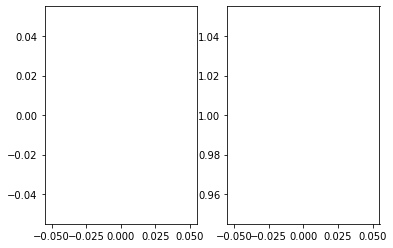

In [37]:
sol = sm.simulate(np.array([0,1]))
time = [i for i in range(len(sol[1]))]
fig,ax = plt.subplots(1,2)
ax[0].plot(time,sol[0])
ax[1].plot(time,sol[1])

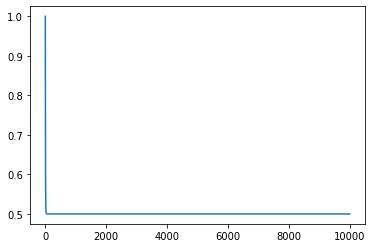

In [31]:
sol


In [23]:
F([1,3]).reshape(1,2)

array([[ 3.45590706e+19, -1.50405332e+01]])

In [29]:
sol = solve(sm._symbolic_eqs,[sm.v,sm.w])
display(sm._symbolic_eqs[0],sm._symbolic_eqs[1])
display(sol)
fv = lambda v: float(list(list(sol)[1].subs(pars).subs({'v':v}))[1])
fw = lambda w: float(list(list(sol)[0].subs(pars).subs({'w':w}))[0])

NotImplementedError: could not solve -a_d*(1 - w)*(exp(b_d*(-v_d + v_w - log(-1 + 1/w)/g_w)) - exp((b_d - 1)*(-v_d + v_w - log(-1 + 1/w)/g_w)))*(exp(g_m*(v_m - v_w + log(-1 + 1/w)/g_w)) + 1) - a_u*w*exp(b_u*(-v_u + v_w - log(-1 + 1/w)/g_w)) - exp((b_u - 1)*(-v_u + v_w - log(-1 + 1/w)/g_w))

In [23]:
sm._symbolic_eqs

[-a_d*(1 - w)*(exp(b_d*(v - v_d)) - exp((b_d - 1)*(v - v_d)))*(exp(g_m*(-v + v_m)) + 1) - a_u*w*exp(b_u*(v - v_u)) - exp((b_u - 1)*(v - v_u)),
 w**k*(-r_w*w*exp(g_w*(b_w - 1)*(v - v_w)) + r_w*(1 - w)*exp(b_w*g_w*(v - v_w)))]

In [10]:
list(sol)[1].subs(pars).subs({'v':5})
fv = lambda v: float(list(list(sol)[1].subs(pars).subs({'v':v}))[1])
fw = lambda w: float(list(list(sol)[0].subs(pars).subs({'w':w}))[0])

In [11]:
list(list(sol)[0].subs(pars).subs({'w':0.7}))

[-0.211824465096801, 0.700000000000000]

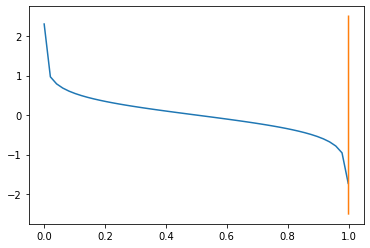

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
X = np.linspace(0.0001,0.999)
Y = [fw(x) for x in X]
plt.plot(X,Y)

V = np.linspace(-2.5001,2.499)
W = [fv(v) for v in V]
plt.plot(W,V)

In [28]:
print(sm.simulate(np.array([1,1])))

ValueError: not enough values to unpack (expected 2, got 1)

In [5]:
type(F_vw)
#f
np.array(f_x).astype('float64')

sm.v,sm.w
F = lambdify([sm.v,sm.w],F_vw)
F(1,3)

array([[ 3.45590706e+19],
       [-1.50405332e+01]])

In [27]:
F(1,3).shape

(2, 1)